<a href="https://colab.research.google.com/github/jiangpinghan/MPTCP-double-proxy/blob/master/DEL_CC_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install 'shimmy>=2.0'

# 新段落

In [ ]:
pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import os
import gym
from gym import spaces
import numpy as np
import torch as th
import matplotlib.pyplot as plt

try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.callbacks import  BaseCallback, EvalCallback
except ImportError:
    !pip install 'shimmy>=2.0'
    !pip install stable_baselines3
    from stable_baselines3 import PPO
    from stable_baselines3.common.callbacks import  BaseCallback, EvalCallback

from tensorboard.backend.event_processing import event_accumulator

# --------------------------
# 自定义 Gym 环境（兼容 SB3）
# --------------------------
class NetworkCongestionEnv(gym.Env):
    def __init__(self):
        super(NetworkCongestionEnv, self).__init__()

        # 动作空间：连续调整比例 [-1, 1] -> 对应窗口变化率 -20%~+20%
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # 状态空间：[窗口, RTT, baseRTT,丢包率]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0]),
            high=np.array([5000, 500, 500, 1]),
            dtype=np.float32
        )

        # 环境参数
        self.max_cwnd = 10       #
        self.current_cwnd = 10    # 当前窗口
        self.base_rtt = 50        # 基准RTT (ms)
        self.current_rtt = 50
        self.base_loss = 0.05     # 基础丢包概率
        self.current_loss = 0.05
        self.time_step = 0

        self.max_rate =  self.max_cwnd/self.base_rtt
        self.max_queue = 150
        self.current_queue = 0

    def _get_state(self):
        """动态生成状态"""
        rtt_variation = np.random.normal(0, 0.1)  # RTT波动率
        bdp = self.current_rtt * self.max_rate
        cong_loss = np.clip( (self.current_queue +self.current_cwnd-bdp-self.max_queue)/self.current_cwnd, 0, 1)
        self.current_loss = self.base_loss * ( 1+np.random.normal(0, 0.5) ) + cong_loss
        self.current_loss = np.clip(self.current_loss,0,1)
        self.current_queue += self.current_cwnd-bdp
        self.current_queue = np.clip(self.current_queue,0,self.max_queue)
        self.current_rtt = np.clip(self.base_rtt+ self.current_queue/self.max_rate,self.base_rtt, (self.base_rtt+ self.max_queue/self.max_rate))
        # print("rtt ",self.current_rtt, "queue", self.current_queue, "loss", self.current_loss)

        return np.array([
            self.current_cwnd,
            self.current_rtt,
            self.base_rtt,
            self.current_loss
        ], dtype=np.float32)

    def step(self, action):
        # 解析动作：将[-1,1]映射到窗口变化率[-20%, +20%]
        delta = 0.2 * float(action[0])
        self.current_cwnd = np.clip(
            self.current_cwnd * (1 + delta),
            1, 5000
        )
        # print(delta,self.current_cwnd)

        # 计算奖励
        throughput = self.current_cwnd / (self.current_rtt/1000) * (1-self.current_loss)
        rtt_penalty = 1 * (self.current_rtt ** 2)
        loss_penalty = 10000 * (self.current_loss)
        reward = throughput - rtt_penalty - loss_penalty

        # reward = throughput * (1-self.current_loss)/ (self.current_rtt/self.base_rtt)
        reward = (throughput - 10000 * self.current_loss)/ (self.current_rtt/self.base_rtt)

        # 终止条件（可选）
        self.time_step += 1
        done = self.time_step >= 200  # 200步为1个episode

        return self._get_state(), reward, done, {}

    def set_net_conditions(self):
        self.max_rate = np.random.uniform(1,10)       #
        self.base_rtt = np.random.uniform(20,30)        # 基准RTT (ms)
        self.base_loss = np.random.uniform(0,0.05)     # 基础丢包概率

        self.max_rate = 4       #
        # self.base_rtt = 50        # 基准RTT (ms)
        # self.base_loss = 0.1     # 基础丢包概率

        self.max_cwnd = self.max_rate * self.base_rtt
        # print(self.max_cwnd)

    def reset(self):
        self.set_net_conditions()
        self.current_cwnd = 10
        self.current_rtt = self.base_rtt
        self.current_loss = self.base_loss
        self.current_queue = 0
        self.time_step = 0

        return self._get_state()

def random_test():

    # 创建环境实例
    env = NetworkCongestionEnv()

    # 设置测试参数
    num_episodes = 1
    episode_length = 200

    for ep in range(num_episodes):
        obs = env.reset()
        obs_list, act_list, cwnd_list, rtt_list, loss_list, queue_list, reward_list = [], [], [], [], [], [], []

        for t in range(episode_length):
            action = env.action_space.sample()
            # action = [1]
            # print(action)
            obs, reward, done, info = env.step(action)

            # 记录数据
            obs_list.append(obs)
            act_list.append(action[0])
            cwnd_list.append(env.current_cwnd)
            rtt_list.append(env.current_rtt)
            loss_list.append(env.current_loss)
            queue_list.append(env.current_queue)
            reward_list.append(reward)

            if done:
                break

    # 可视化窗口变化
    plt.figure(figsize=(10, 4))
    plt.plot(cwnd_list, label="CWND")
    plt.xlabel("Step")
    plt.ylabel("Congestion Window Size")
    plt.title(f"Episode {ep+1} - Window Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 4))
    plt.plot(rtt_list, label="rtt")
    plt.xlabel("Step")
    plt.ylabel("RTT")
    plt.title(f"Episode {ep+1} - Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(loss_list, label="loss rate")
    plt.xlabel("Step")
    plt.ylabel("loss")
    plt.title(f"Episode {ep+1} - Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(queue_list, label="queue on switch")
    plt.xlabel("Step")
    plt.ylabel("queue")
    plt.title(f"Episode {ep+1} - Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 可选：打印总奖励
    print(f"Episode {ep+1}: Total Reward = {np.sum(reward_list):.2f}")

def test(model_path):

    # 加载训练好的模型
    model = PPO.load(model_path)

    # 创建环境实例
    env = NetworkCongestionEnv()

    # 设置测试参数
    num_episodes = 1
    episode_length = 200

    for ep in range(num_episodes):
        obs = env.reset()
        obs_list, act_list, cwnd_list, rtt_list, loss_list, queue_list, reward_list = [], [], [], [], [], [], []

        for t in range(episode_length):
            action, _states = model.predict(obs, deterministic=True)
            # print(action)
            obs, reward, done, info = env.step(action)

            # 记录数据
            obs_list.append(obs)
            act_list.append(action[0])
            cwnd_list.append(env.current_cwnd)
            rtt_list.append(env.current_rtt)
            loss_list.append(env.current_loss)
            queue_list.append(env.current_queue)
            reward_list.append(reward)

            if done:
                break

    # 可视化窗口变化
    plt.figure(figsize=(10, 4))
    plt.plot(cwnd_list, label="CWND")
    plt.xlabel("Step")
    plt.ylabel("Congestion Window Size")
    plt.title(f"Episode {ep+1} - Window Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(rtt_list, label="rtt")
    plt.xlabel("Step")
    plt.ylabel("RTT")
    plt.title(f"Episode {ep+1} - Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(loss_list, label="loss rate")
    plt.xlabel("Step")
    plt.ylabel("loss")
    plt.title(f"Episode {ep+1} - Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(queue_list, label="queue on switch")
    plt.xlabel("Step")
    plt.ylabel("queue")
    plt.title(f"Episode {ep+1} - Evolution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 可选：打印总奖励
    print(f"Episode {ep+1}: Total Reward = {np.sum(reward_list):.2f}")
    print("max_cwnd ",env.max_cwnd)

def plot_tensorboard_losses(log_dir):
    """
    从TensorBoard日志中提取损失数据并绘制曲线
    """
    # 获取所有日志文件
    log_files = []
    for root, _, files in os.walk(log_dir):
        for file in files:
            if "events.out.tfevents" in file:
                log_files.append(os.path.join(root, file))

    if not log_files:
        print("未找到TensorBoard日志文件")
        return

    # 使用最新日志文件
    latest_log = max(log_files, key=os.path.getctime)

    # 创建事件累积器
    ea = event_accumulator.EventAccumulator(latest_log)
    ea.Reload()  # 加载事件

    # 获取所有标签
    tags = ea.Tags()['scalars']

    # 只提取损失相关的标签
    loss_tags = [tag for tag in tags if 'loss' in tag.lower()]

    if not loss_tags:
        print("未找到损失数据")
        return

    # 创建图表
    plt.figure(figsize=(15, 10))

    # 为每个损失标签绘制曲线
    for i, tag in enumerate(loss_tags):
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]

        plt.subplot(2, 2, i+1)
        plt.plot(steps, values)
        plt.xlabel('Timesteps')
        plt.ylabel(tag.split('/')[-1])
        plt.title(tag)
        plt.grid(True)

    plt.tight_layout()


    plt.show()



# 自定义回调函数用于记录损失
class LossCallback(BaseCallback):
    """
    自定义回调函数，用于记录训练过程中的损失值
    """
    def __init__(self, verbose=0):
        super(LossCallback, self).__init__(verbose)
        self.losses = []
        self.timesteps = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        """
        每一步训练后调用，记录损失值
        """
        # 每100步记录一次损失
        if self.num_timesteps % 100 == 0:
            # 获取最近一次更新的损失值
            if len(self.model.ep_info_buffer) > 0 and len(self.model.ep_info_buffer[0]) > 0:
                # 记录总损失
                loss = self.model.ep_info_buffer[0].get('loss', None)
                # print(loss)
                if loss is not None:
                    self.losses.append(loss)
                    self.timesteps.append(self.num_timesteps)

                # 记录episode长度
                episode_length = self.model.ep_info_buffer[0].get('l', None)
                if episode_length is not None:
                    self.episode_lengths.append(episode_length)
        return True

    def plot_loss(self):
        """
        绘制损失曲线并保存
        """
        if not self.losses:
            print("No loss data to plot.")
            return

        plt.figure(figsize=(12, 8))

        # 绘制损失曲线
        plt.subplot(2, 1, 1)
        plt.plot(self.timesteps, self.losses)
        plt.xlabel('Timesteps')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.grid(True)

        # 绘制episode长度曲线
        if self.episode_lengths:
            plt.subplot(2, 1, 2)
            plt.plot(self.timesteps[:len(self.episode_lengths)], self.episode_lengths)
            plt.xlabel('Timesteps')
            plt.ylabel('Episode Length')
            plt.title('Episode Length Over Time')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

def train(model_dir, log_dir, model_path):
    # 确保日志目录存在
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # 创建环境
    env = NetworkCongestionEnv()

    # 定义策略网络架构
    policy_kwargs = dict(
        activation_fn=th.nn.ReLU,
        net_arch=[dict(pi=[64, 64], vf=[64, 64])]
    )

    # 初始化PPO模型
    model = PPO(
        "MlpPolicy",
        env,
        policy_kwargs=policy_kwargs,
        verbose=1,
        learning_rate=3e-4,
        gamma=0.95,
        n_steps=1024,
        batch_size=64,
        clip_range=0.2,
        tensorboard_log=log_dir
    )

    # 评估回调
    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=5000,
        deterministic=True,
        render=False
    )

    # 损失记录回调
    loss_callback = LossCallback()

    # 训练
    model.learn(
        total_timesteps=5e4,
        callback=[eval_callback, loss_callback],  # 使用多个回调
        tb_log_name="ppo_congestion"
    )

    # 保存模型
    model.save(model_path)

    # 绘制损失曲线
    loss_callback.plot_loss()

    plot_tensorboard_losses(log_dir)

    # 返回损失数据以备进一步分析
    return loss_callback.losses, loss_callback.timesteps


# if __name__ == "__main__":

#     # 获取当前脚本所在的绝对路径
#     script_dir = os.path.dirname(os.path.abspath(__file__))

#     # 定义子目录路径
#     model_dir = os.path.join(script_dir, "models")
#     log_dir = os.path.join(script_dir, "logs")
#     model_path = os.path.join(model_dir, "ppo_congestion_ctrl")

#     losses, timesteps = train(model_dir, log_dir, model_path)
#     test(model_path)
#     # random_test()

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


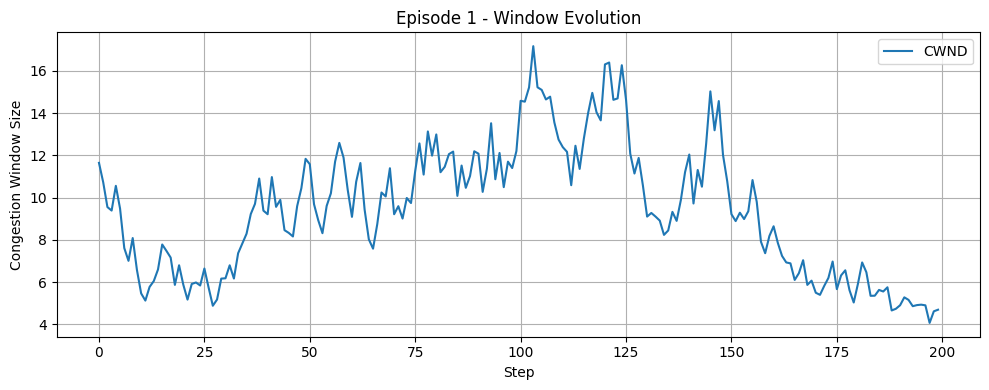

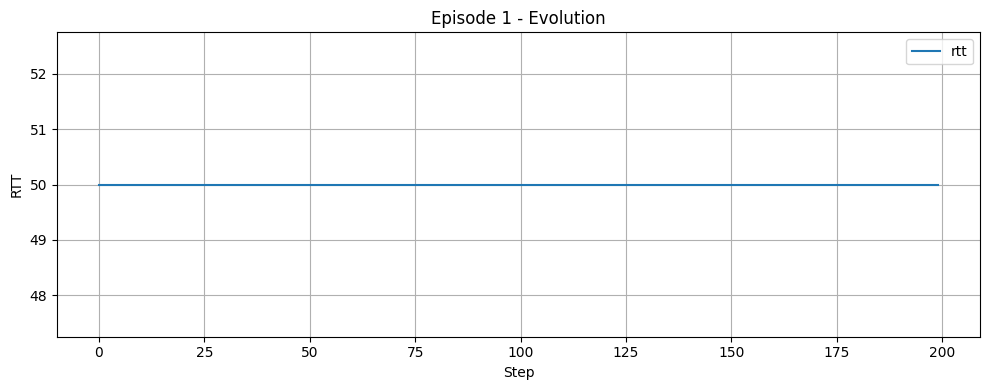

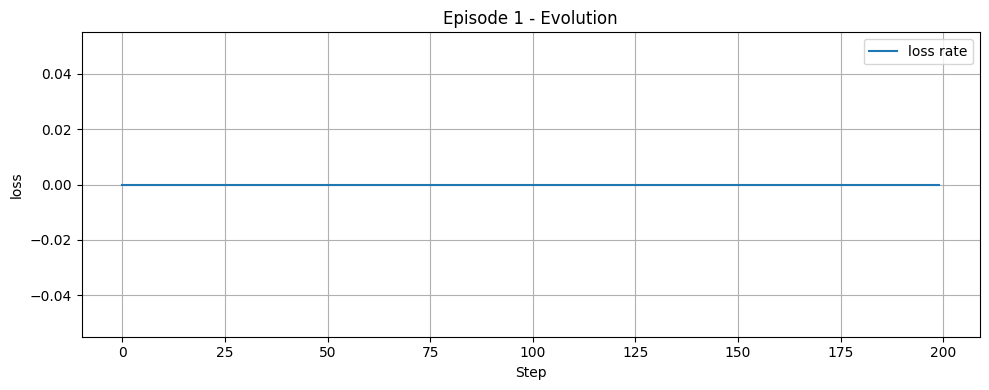

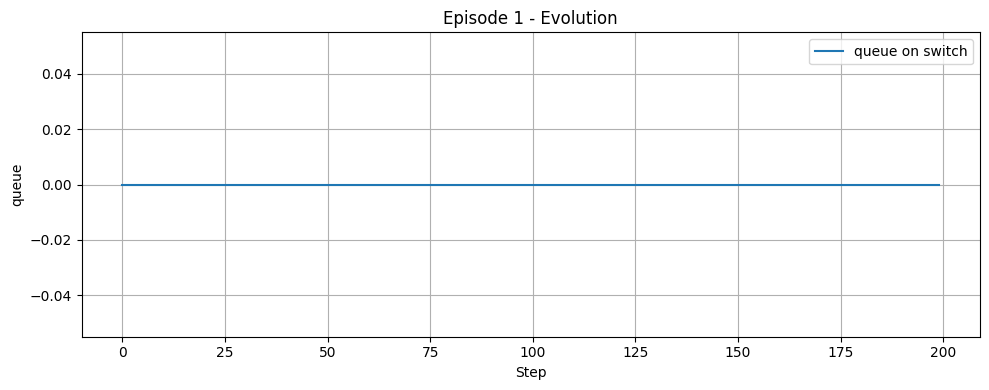

Episode 1: Total Reward = 37663.78


In [ ]:
random_test()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to DRL-CC-simple/logs/ppo_congestion_4


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 5.5e+03  |
| time/              |          |
|    fps             | 1299     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | 1.11e+05    |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008953607 |
|    clip_fraction        | 0.0837      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.000636   |
|    learning_rate        | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=130548.24 +/- 63552.22
Episode length: 200.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 200           |
|    mean_reward          | 1.31e+05      |
| time/                   |               |
|    total_timesteps      | 5000          |
| train/                  |               |
|    approx_kl            | 0.00015190605 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.00617       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.37e+08      |
|    n_updates            | 40            |
|    policy_gradient_loss | -0.000143     |
|    std                  | 0.999         |
|    value_loss           | 2.45e+08      |
-------------------------------------------
New best mean reward!
---------------------------------
| rollout/   

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-256415.05 +/- 97828.89
Episode length: 200.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 200        |
|    mean_reward          | -2.56e+05  |
| time/                   |            |
|    total_timesteps      | 10000      |
| train/                  |            |
|    approx_kl            | 0.08279672 |
|    clip_fraction        | 0.0574     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.42      |
|    explained_variance   | 0.612      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.44e+07   |
|    n_updates            | 90         |
|    policy_gradient_loss | 0.00748    |
|    std                  | 0.999      |
|    value_loss           | 2.18e+08   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     |

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=15000, episode_reward=66645.84 +/- 127801.95
Episode length: 200.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 200           |
|    mean_reward          | 6.66e+04      |
| time/                   |               |
|    total_timesteps      | 15000         |
| train/                  |               |
|    approx_kl            | 3.3688848e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.0622        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.56e+07      |
|    n_updates            | 140           |
|    policy_gradient_loss | -8.5e-05      |
|    std                  | 0.999         |
|    value_loss           | 2.17e+08      |
-------------------------------------------
---------------------------------
| rollout/           |          |


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=-26606.93 +/- 39671.51
Episode length: 200.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 200           |
|    mean_reward          | -2.66e+04     |
| time/                   |               |
|    total_timesteps      | 20000         |
| train/                  |               |
|    approx_kl            | 0.00046239205 |
|    clip_fraction        | 0.000781      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | -0.618        |
|    learning_rate        | 0.0003        |
|    loss                 | 5.09e+07      |
|    n_updates            | 190           |
|    policy_gradient_loss | -0.000506     |
|    std                  | 0.999         |
|    value_loss           | 1.76e+08      |
-------------------------------------------
---------------------------------
| rollout/           |          |


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-24730.43 +/- 50805.79
Episode length: 200.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 200          |
|    mean_reward          | -2.47e+04    |
| time/                   |              |
|    total_timesteps      | 25000        |
| train/                  |              |
|    approx_kl            | 0.0010380168 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.148        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.31e+07     |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.000414    |
|    std                  | 0.999        |
|    value_loss           | 1.84e+08     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean   

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=337896.54 +/- 6813.27
Episode length: 200.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 200          |
|    mean_reward          | 3.38e+05     |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0002752415 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0203       |
|    learning_rate        | 0.0003       |
|    loss                 | 5.07e+07     |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000621    |
|    std                  | 0.999        |
|    value_loss           | 1.15e+08     |
------------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=35000, episode_reward=409919.31 +/- 20401.03
Episode length: 200.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 200         |
|    mean_reward          | 4.1e+05     |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.007488299 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.24e+07    |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00699    |
|    std                  | 0.999       |
|    value_loss           | 9.27e+07    |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=-235766.60 +/- 91589.59
Episode length: 200.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 200          |
|    mean_reward          | -2.36e+05    |
| time/                   |              |
|    total_timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.0042416686 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.44         |
|    learning_rate        | 0.0003       |
|    loss                 | 5.31e+07     |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00491     |
|    std                  | 0.999        |
|    value_loss           | 7.63e+07     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=45000, episode_reward=-80120.38 +/- 77015.04
Episode length: 200.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 200          |
|    mean_reward          | -8.01e+04    |
| time/                   |              |
|    total_timesteps      | 45000        |
| train/                  |              |
|    approx_kl            | 0.0013086059 |
|    clip_fraction        | 0.00801      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.615        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.94e+07     |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00194     |
|    std                  | 0.999        |
|    value_loss           | 1.48e+08     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean   

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=50000, episode_reward=-156092.49 +/- 103193.33
Episode length: 200.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 200          |
|    mean_reward          | -1.56e+05    |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.0011345975 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.783        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.94e+07     |
|    n_updates            | 480          |
|    policy_gradient_loss | 0.000857     |
|    std                  | 0.999        |
|    value_loss           | 1.75e+08     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean 

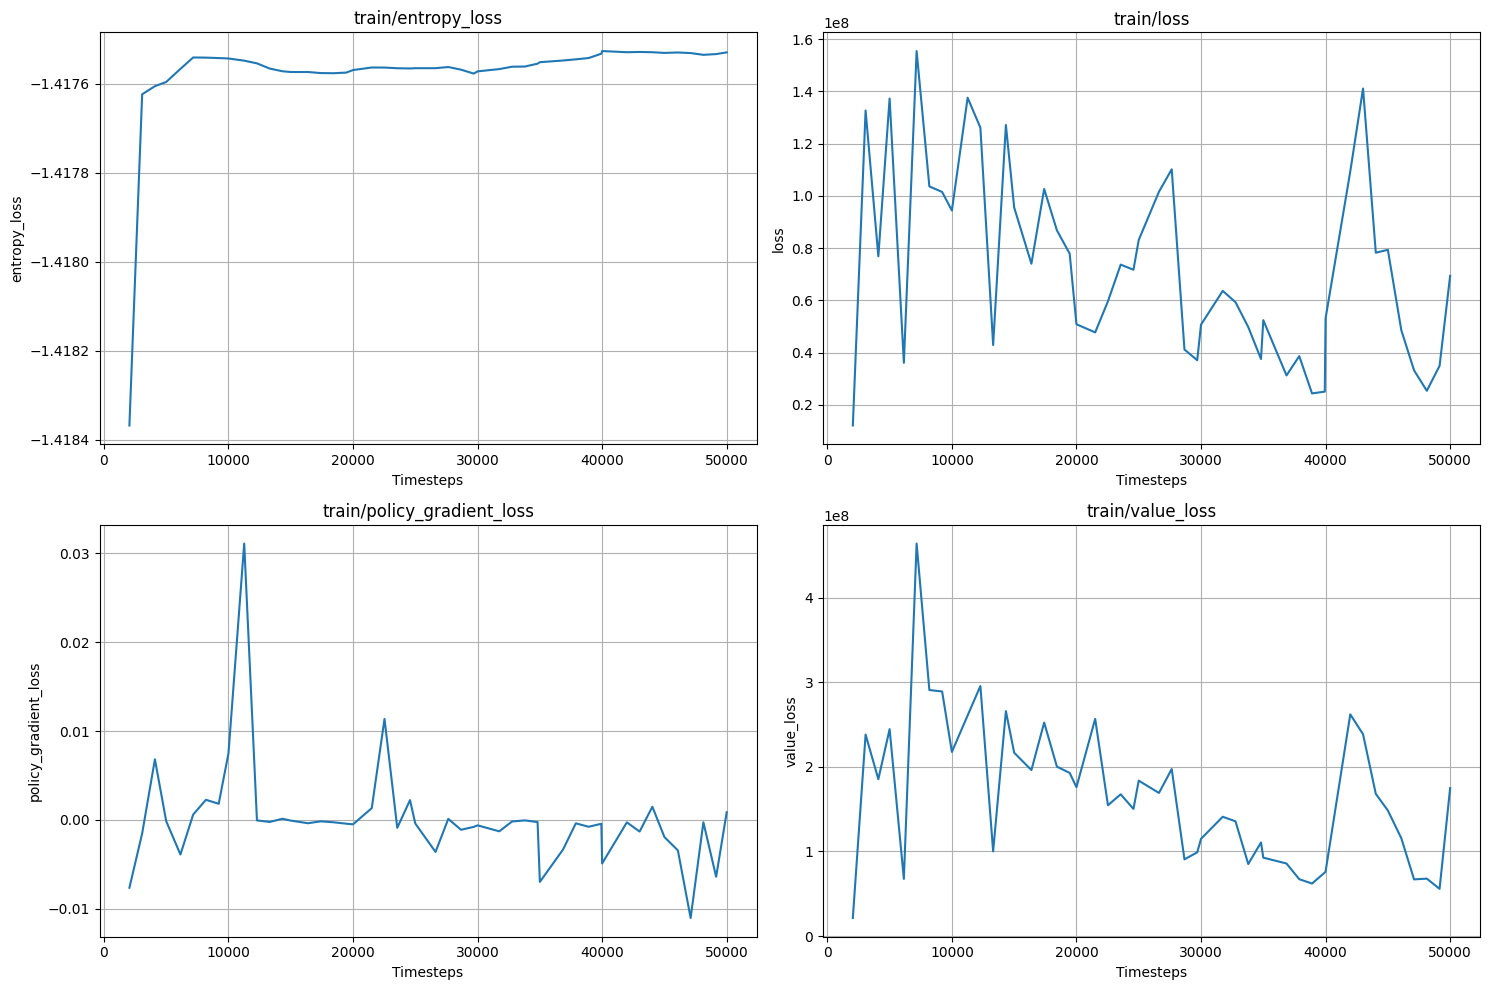

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


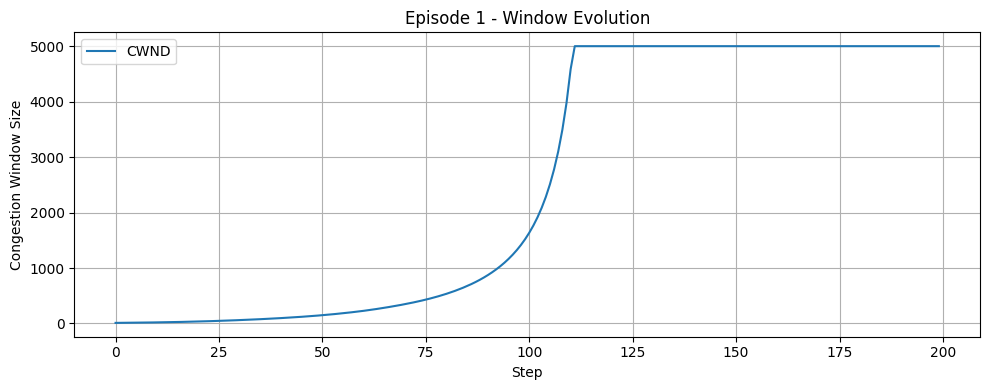

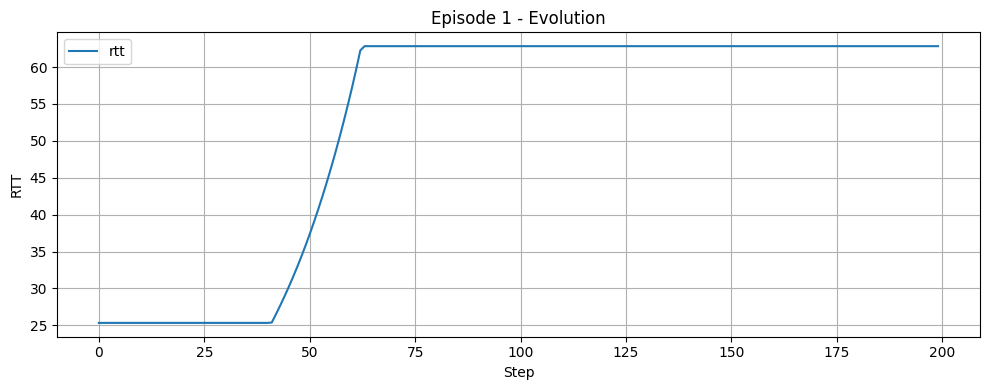

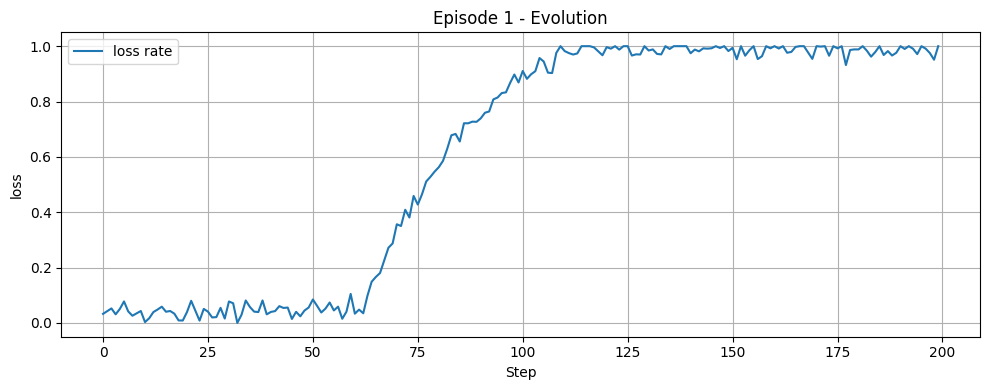

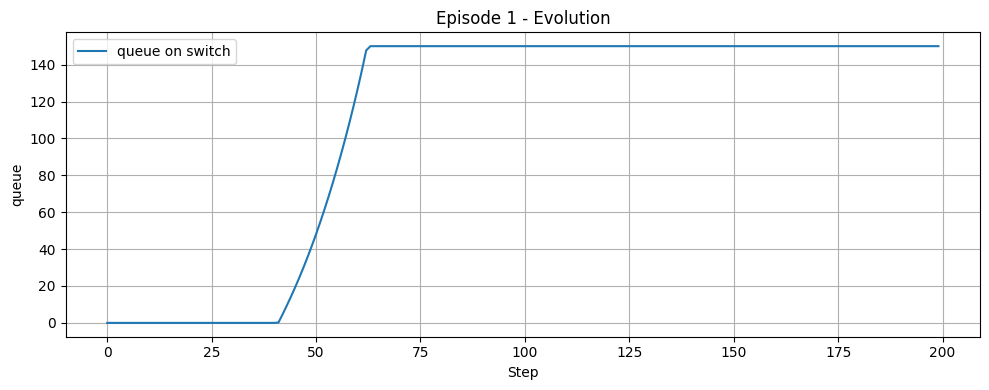

Episode 1: Total Reward = -264589.46
max_cwnd  101.31330152133229


In [ ]:

script_dir = "DRL-CC-simple/"

# 定义子目录路径
model_dir = os.path.join(script_dir, "models")
log_dir = os.path.join(script_dir, "logs")
model_path = os.path.join(model_dir, "ppo_congestion_ctrl")

# 定义子目录路径
# model_dir = "models"
# log_dir = "logs"
# model_path = "ppo_congestion_ctrl"

losses, timesteps = train(model_dir, log_dir, model_path)
test(model_path)
